In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
import xlrd
import os
import re
from scipy import stats
from scipy.stats import kstest
from scipy.spatial.distance import directed_hausdorff
from scipy import optimize
import pwlf
import pwlf1
from scipy.optimize import minimize
from pyecharts import options as opts
from pyecharts.charts import Calendar
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from chinese_calendar import is_workday, is_holiday, is_in_lieu
from scipy.optimize import linprog
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [2]:
# load day ahead price data from E:\day-ahead price\Data\ISO_New_England\day_ahead_price
path = r'E:\day-ahead price\Data\ISO_New_England\day_ahead_price'
os.chdir(path)
files = os.listdir(path)
df = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    # print(df_tmp)
    df = pd.concat([df, df_tmp])
df.columns = df.iloc[4]
df = df[df['H'] == 'D'].drop(['H'], axis = 1).reset_index(drop = True)
# average price by Date and Hour Ending
tmp = []
df['Hour Ending'] = df['Hour Ending'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Locational Marginal Price'] = df['Locational Marginal Price'].astype(float)
df['Energy Component'] = df['Energy Component'].astype(float)
df['Congestion Component'] = df['Congestion Component'].astype(float)
df['Marginal Loss Component'] = df['Marginal Loss Component'].astype(float)
df_group = df.groupby(['Date', 'Hour Ending'])
for [Date, Hour_Ending], group in df_group:
    Locational_Marginal_Price = group['Locational Marginal Price'].mean() 
    Energy_Component = group['Energy Component'].mean()
    Congestion_Component = group['Congestion Component'].mean()
    Marginal_Loss_Component = group['Marginal Loss Component'].mean()
    tmp.append([Date, Hour_Ending, Locational_Marginal_Price, Energy_Component, Congestion_Component, Marginal_Loss_Component])
df_price = pd.DataFrame(tmp, columns = ['Date', 'Hour Ending', 'Locational Marginal Price', 'Energy Component', 'Congestion Component', 'Marginal Loss Component'])
df_price

,Date,Hour Ending,Locational Marginal Price,Energy Component,Congestion Component,Marginal Loss Component
0,2022-01-01,01,32.124229,32.35,-0.089337,-0.136434
1,2022-01-01,02,32.057678,32.31,-0.111808,-0.140514
2,2022-01-01,03,30.726426,30.85,0.000000,-0.123574
3,2022-01-01,04,29.569668,29.69,0.000000,-0.120332
4,2022-01-01,05,30.738126,30.86,0.000000,-0.121874
...,...,...,...,...,...,...
16315,2023-11-11,20,40.609046,40.90,-0.030929,-0.260025
16316,2023-11-11,21,40.179589,40.43,-0.028840,-0.221571
16317,2023-11-11,22,39.871406,40.09,-0.032385,-0.186209
16318,2023-11-11,23,29.190831,29.34,-0.002179,-0.146990


In [3]:
# df_price lack a line of data in Date 2023-03-12, Hour Ending 3, so we need to add this line by average of Hour Ending 2 and Hour Ending 4
lost_data = pd.DataFrame({'Date': '2023-03-12', 'Hour Ending': '03', 'Locational Marginal Price': (df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '02')]['Locational Marginal Price'].values[0] + df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '04')]['Locational Marginal Price'].values[0])/2, 'Energy Component': (df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '02')]['Energy Component'].values[0] + df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '04')]['Energy Component'].values[0])/2, 'Congestion Component': (df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '02')]['Congestion Component'].values[0] + df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '04')]['Congestion Component'].values[0])/2, 'Marginal Loss Component': (df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '02')]['Marginal Loss Component'].values[0] + df_price[(df_price['Date'] == '2023-03-12') & (df_price['Hour Ending'] == '04')]['Marginal Loss Component'].values[0])/2}, index = [0])
df_price = pd.concat([df_price, lost_data]).sort_values(by = ['Date', 'Hour Ending']).reset_index(drop = True)
# delete the line of data in Date 2023-11-05, whose Hour Ending = '02X' 
df_price = df_price.drop(df_price[(df_price['Date'] == '2023-11-05') & (df_price['Hour Ending'] == '02X')].index).reset_index(drop = True)
# delete the line of data in Date 2022-11-06, whose Hour Ending = '02X' 
df_price = df_price.drop(df_price[(df_price['Date'] == '2022-11-06') & (df_price['Hour Ending'] == '02X')].index).reset_index(drop = True)
df_price['Hour Ending'] = df_price['Hour Ending'].astype(int)
df_price

,Date,Hour Ending,Locational Marginal Price,Energy Component,Congestion Component,Marginal Loss Component
0,2022-01-01,1,32.124229,32.35,-0.089337,-0.136434
1,2022-01-01,2,32.057678,32.31,-0.111808,-0.140514
2,2022-01-01,3,30.726426,30.85,0.000000,-0.123574
3,2022-01-01,4,29.569668,29.69,0.000000,-0.120332
4,2022-01-01,5,30.738126,30.86,0.000000,-0.121874
...,...,...,...,...,...,...
16314,2023-11-11,20,40.609046,40.90,-0.030929,-0.260025
16315,2023-11-11,21,40.179589,40.43,-0.028840,-0.221571
16316,2023-11-11,22,39.871406,40.09,-0.032385,-0.186209
16317,2023-11-11,23,29.190831,29.34,-0.002179,-0.146990


In [4]:
# load real capacity data from E:\day-ahead price\Data\ISO_New_England\real_capacity
path = r'E:\day-ahead price\Data\ISO_New_England\real_capacity'
os.chdir(path)
files = os.listdir(path)
df_peak_load = pd.DataFrame()
df_capa = pd.DataFrame()
df_interchange = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    df_tmp = df_tmp.iloc[8:50, :].reset_index(drop=True)

    prior_date = pd.to_datetime(df_tmp.iloc[1, 1])
    Hour_Ending = int(df_tmp.iloc[1, 2])
    peak_load = float(df_tmp.iloc[1, 3])
    df_peak_load = pd.concat([df_peak_load, pd.DataFrame([[prior_date, Hour_Ending, peak_load]], columns=['Date', 'Hour Ending', 'Peak Load'])], axis=0)

    report_date = prior_date + datetime.timedelta(1)
    Capacity_Supply_Obligation = float(df_tmp.iloc[4, 2])
    Capacity_Additions_EcoMax_Bid_CSO = float(df_tmp.iloc[5, 2])	
    Generation_Outages_and_Reductions = float(df_tmp.iloc[6, 2])
    Uncommitted_Available_Generation = float(df_tmp.iloc[7, 2])
    DRR_Capacity = float(df_tmp.iloc[8, 2])
    Uncommitted_Available_DRR = float(df_tmp.iloc[9, 2])
    Net_Deliveries = float(df_tmp.iloc[17, 2])
    Total_Available_Capacity = float(df_tmp.iloc[18, 2])
    Peak_Load_Forecast = float(df_tmp.iloc[19, 2])
    Total_Operating_Reserve_Requirements = float(df_tmp.iloc[20, 2])
    Capacity_Required = float(df_tmp.iloc[21, 2])
    Surplus_Deficiency = float(df_tmp.iloc[22, 2])
    Replacement_Reserve_Requirement = float(df_tmp.iloc[23, 2])
    Excess_Commitment_Surplus_Deficiency = float(df_tmp.iloc[24, 2])
    df_capa = pd.concat([df_capa, pd.DataFrame([[report_date, Hour_Ending, Capacity_Supply_Obligation, Capacity_Additions_EcoMax_Bid_CSO, Generation_Outages_and_Reductions, Uncommitted_Available_Generation, DRR_Capacity, Uncommitted_Available_DRR, Net_Deliveries, Total_Available_Capacity, Peak_Load_Forecast, Total_Operating_Reserve_Requirements, Capacity_Required, Surplus_Deficiency, Replacement_Reserve_Requirement, Excess_Commitment_Surplus_Deficiency]], columns=['Date', 'Hour Ending', 'Capacity Supply Obligation', 'Capacity Additions EcoMax Bid CSO', 'Generation Outages and Reductions', 'Uncommitted Available Generation', 'DRR Capacity', 'Uncommitted Available DRR', 'Net Deliveries', 'Total Available Capacity', 'Peak Load Forecast', 'Total Operating Reserve Requirements', 'Capacity Required', 'Surplus Deficiency', 'Replacement Reserve Requirement', 'Excess Commitment Surplus Deficiency'])], axis=0)

    tmp_interchange = df_tmp.iloc[35:, 1:].reset_index(drop=True)
    tmp_interchange.columns = tmp_interchange.iloc[0]
    tmp_interchange = tmp_interchange.iloc[1:, :].reset_index(drop=True)
    tmp_interchange['Date'] = report_date
    df_interchange = pd.concat([df_interchange, tmp_interchange], axis=0)
    
df_peak_load = df_peak_load.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
df_capa = df_capa.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
df_interchange = df_interchange.drop_duplicates(subset=['Date', 'Description'], keep='first').reset_index(drop=True)
df_capa

,Date,Hour Ending,Capacity Supply Obligation,Capacity Additions EcoMax Bid CSO,Generation Outages and Reductions,Uncommitted Available Generation,DRR Capacity,Uncommitted Available DRR,Net Deliveries,Total Available Capacity,Peak Load Forecast,Total Operating Reserve Requirements,Capacity Required,Surplus Deficiency,Replacement Reserve Requirement,Excess Commitment Surplus Deficiency
0,2022-01-01,18,29741.0,1491.0,2621.0,13055.0,233.0,12.0,-3394.0,19171.0,14220.0,2209.0,16429.0,2742.0,180.0,2562.0
1,2022-01-02,18,29741.0,1970.0,1930.0,13834.0,232.0,12.0,-3088.0,19255.0,15400.0,2209.0,17609.0,1646.0,180.0,1466.0
2,2022-01-03,18,29741.0,2124.0,1806.0,11739.0,331.0,12.0,-2794.0,21433.0,18000.0,2209.0,20209.0,1224.0,180.0,1044.0
3,2022-01-04,18,29741.0,1867.0,2509.0,11443.0,322.0,12.0,-3146.0,21112.0,17570.0,2209.0,19779.0,1333.0,180.0,1153.0
4,2022-01-05,18,29741.0,1817.0,2524.0,9464.0,325.0,12.0,-1837.0,21720.0,16700.0,2209.0,18909.0,2811.0,180.0,2631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,2023-11-07,18,28377.0,1129.0,9637.0,4125.0,220.0,12.0,-2401.0,18353.0,14500.0,2108.0,16608.0,1745.0,180.0,1565.0
676,2023-11-08,18,28377.0,1769.0,8918.0,4023.0,220.0,12.0,-2383.0,19796.0,15280.0,2053.0,17333.0,2463.0,180.0,2283.0
677,2023-11-09,18,28377.0,974.0,9639.0,3207.0,226.0,12.0,-2002.0,18721.0,15360.0,2110.0,17470.0,1251.0,180.0,1071.0
678,2023-11-10,18,28377.0,1268.0,9118.0,4559.0,224.0,12.0,-2145.0,18325.0,14830.0,2068.0,16898.0,1427.0,180.0,1247.0


In [5]:
# load real load data from E:\day-ahead price\Data\ISO_New_England\real_load
path = r'E:\day-ahead price\Data\ISO_New_England\real_load'
os.chdir(path)
files = os.listdir(path)
df_real_load = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    df_tmp.columns = df_tmp.iloc[4]
    df_tmp = df_tmp[df_tmp['H'] == 'D'].iloc[:, 1:].reset_index(drop=True)
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    df_tmp = df_tmp[df_tmp['Hour Ending'] != '02X']
    df_tmp['Hour Ending'] = df_tmp['Hour Ending'].astype(int)
    df_tmp['Day-Ahead Cleared Demand'] = df_tmp['Day-Ahead Cleared Demand'].astype(float)
    df_real_load = pd.concat([df_real_load, df_tmp], axis=0)
df_real_load

4,Date,Hour Ending,Day-Ahead Cleared Demand
0,2022-10-01,1,9518.0
1,2022-10-01,2,9639.0
2,2022-10-01,3,9445.0
3,2022-10-01,4,9317.0
4,2022-10-01,5,9460.0
...,...,...,...
356,2023-11-11,20,13427.0
357,2023-11-11,21,13145.0
358,2023-11-11,22,12383.0
359,2023-11-11,23,11749.0


In [6]:
# df_real_load lack a line of data in Date 2023-03-12, Hour Ending 3, so we need to add this line by average of Hour Ending 2 and Hour Ending 4
df_tmp = df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 2)].reset_index(drop=True)
df_tmp['Hour Ending'] = 3
df_tmp['Day-Ahead Cleared Demand'] = (df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 2)]['Day-Ahead Cleared Demand'].values + df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 4)]['Day-Ahead Cleared Demand'].values) / 2
df_real_load = pd.concat([df_real_load, df_tmp], axis=0).reset_index(drop=True).sort_values(by=['Date', 'Hour Ending']).reset_index(drop=True)
df_real_load

4,Date,Hour Ending,Day-Ahead Cleared Demand
0,2022-10-01,1,9518.0
1,2022-10-01,2,9639.0
2,2022-10-01,3,9445.0
3,2022-10-01,4,9317.0
4,2022-10-01,5,9460.0
...,...,...,...
9763,2023-11-11,20,13427.0
9764,2023-11-11,21,13145.0
9765,2023-11-11,22,12383.0
9766,2023-11-11,23,11749.0


In [7]:

df_realpower_realcapa = pd.merge(df_real_load, df_capa.drop(['Hour Ending'], axis=1), on=['Date'], how='inner')

df_realpower_realcapa['thermal'] = df_realpower_realcapa['Day-Ahead Cleared Demand']
df_realpower_realcapa['thermal/capa'] = df_realpower_realcapa['thermal'] / df_realpower_realcapa['Total Available Capacity']


In [30]:
df_realpower_realcapa['Date'] = pd.to_datetime(df_realpower_realcapa['Date'])
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_aligend = pd.merge(df_realpower_realcapa, df_price, on=['Date', 'Hour Ending'])
df_aligend = df_aligend[(df_aligend['Date'] >= '2023-01-01') & (df_aligend['Date'] <= '2023-9-30')].reset_index(drop=True)
price = df_aligend['Locational Marginal Price']
load_rate = df_aligend['thermal/capa']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


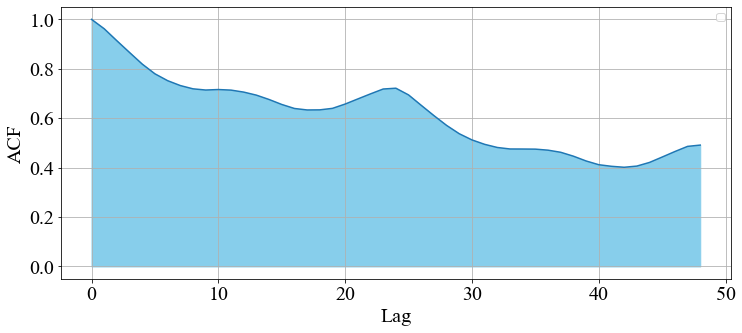

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# 计算 ACF
acf_values = acf(price, nlags=48)

# 创建 x 轴的值
lags = np.arange(0, len(acf_values))

# 使用 matplotlib 绘制连续的 ACF 图
plt.figure(figsize=(12, 5))
plt.plot(lags, acf_values)  # 去掉了 marker='o'
plt.fill_between(lags, acf_values, color='skyblue')  # 填充颜色
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
# 设置坐标轴刻度的字体大小和颜色
plt.tick_params(axis='both', labelsize=20, labelcolor='black')

# 设置图例的字体大小
plt.legend(fontsize=11)
os.chdir(r'E:\day-ahead price\Code\Code')
plt.savefig('acf2_iso.pdf', dpi=1200, format='pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


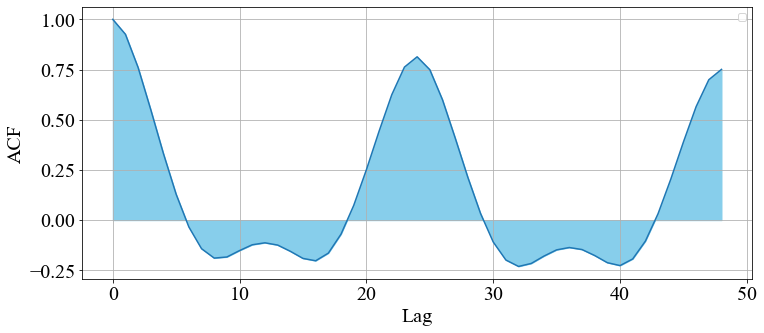

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# 计算 ACF
acf_values = acf(load_rate, nlags=48)

# 创建 x 轴的值
lags = np.arange(0, len(acf_values))

# 使用 matplotlib 绘制连续的 ACF 图
plt.figure(figsize=(12, 5))
plt.plot(lags, acf_values)  # 去掉了 marker='o'
plt.fill_between(lags, acf_values, color='skyblue')  # 填充颜色
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
# 设置坐标轴刻度的字体大小和颜色
plt.tick_params(axis='both', labelsize=20, labelcolor='black')

# 设置图例的字体大小
plt.legend(fontsize=11)
os.chdir(r'E:\day-ahead price\Code\Code')
plt.savefig('acf1_iso.pdf', dpi=1200, format='pdf', bbox_inches='tight')
plt.show()

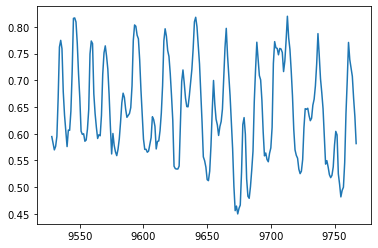

In [9]:
plt.plot(load_rate[-10*24:])
plt.show()

C:\Users\16562\AppData\Local\Temp\ipykernel_4364\2486329864.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(load_rate, lags=48).show()


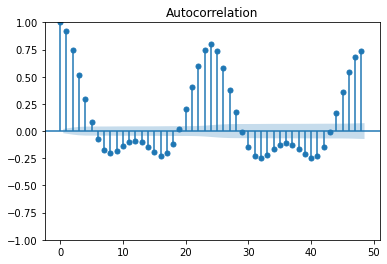

In [10]:
plot_acf(load_rate, lags=48).show()

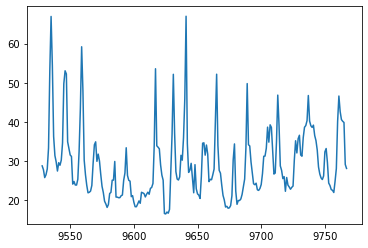

In [11]:

plt.plot(price[-10*24:])
plt.show()

C:\Users\16562\AppData\Local\Temp\ipykernel_4364\3017467039.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(price, lags=48).show()


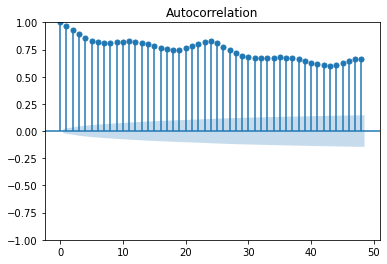

In [12]:
plot_acf(price, lags=48).show()

In [13]:
# caculate the correlation between load_rate and price
np.corrcoef(load_rate, price)

array([[1.        , 0.33700325],
       [0.33700325, 1.        ]])

In [14]:
df_aligend[['Locational Marginal Price', 'thermal/capa']].corr(method='spearman')

,Locational Marginal Price,thermal/capa
Locational Marginal Price,1.000000,0.509108
thermal/capa,0.509108,1.000000


In [15]:
def get_price_data(date):
    return df_price[df_price['Date'] == date]['Locational Marginal Price'].values

def get_load_data(date):
    return df_realpower_realcapa[df_realpower_realcapa['Date'] == date]['thermal/capa'].values

def loss(target, prediction):
    if np.isnan(target).all() or np.isnan(prediction).all():
        return 0, 0, 0, 0
    from math import sqrt
    error = []
    pError = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
        
        # if target[i] < 55:
        #     a = 55
        # else:
        #     a = target[i]
        # if prediction[i] < 55:
        #     b = 55
        # else:
        #     b = prediction[i]
        pError.append(abs(target[i] - prediction[i]) / ((abs(target[i]) + abs(prediction[i]))/2))

    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)#target-prediction之差平方 
        absError.append(abs(val))#误差绝对值
    mse = sum(squaredError) / len(squaredError)#均方误差MSE
    rmse = sqrt(sum(squaredError) / len(squaredError))#均方根误差RMSE
    mae = sum(absError) / len(absError)#平均绝对误差MAE
    smape = sum(pError) / len(absError)
    return mse, rmse, mae, smape

In [42]:
smape_list = []
smape_list1 = []
for _ in pd.date_range('2023-04-01', '2023-10-31'):
    df_1 = get_price_data(_ - datetime.timedelta(1))
    df_2 = get_price_data(_)
    mse, rmse, mae, smape = loss(df_1, df_2)
    smape_list.append(smape)
    df_1 = get_load_data(_ - datetime.timedelta(1))
    df_2 = get_load_data(_)
    mse, rmse, mae, smape = loss(df_1, df_2)
    smape_list1.append(smape)
smape_list = pd.Series(smape_list).dropna()
smape_list1 = pd.Series(smape_list1).dropna()
smape_list

0      0.223002
1      0.208273
2      0.188615
3      0.198324
4      0.188339
         ...   
209    0.107914
210    0.138340
211    0.165679
212    0.222355
213    0.247796
Length: 214, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


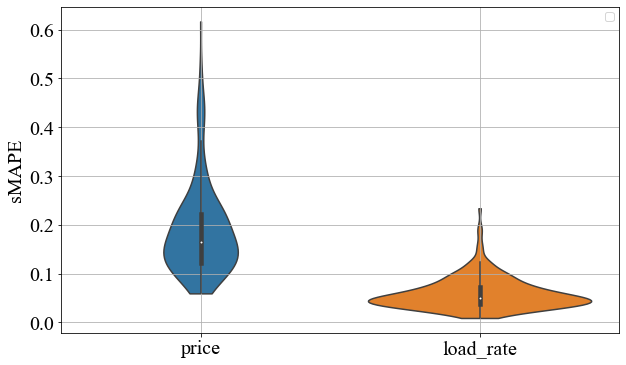

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设数据
price = smape_list
load_rate = smape_list1

data = [price, load_rate]
labels = ['price', 'load_rate']
# 创建小提琴图
plt.figure(figsize=(10,6))
sns.violinplot(data=data, cut=0)  # 设置cut=0
plt.xticks(np.arange(2), labels)
plt.ylabel('sMAPE')
plt.grid(True)
# 设置坐标轴刻度的字体大小和颜色
plt.tick_params(axis='both', labelsize=20, labelcolor='black')

# 设置图例的字体大小
plt.legend(fontsize=11)
os.chdir(r'E:\day-ahead price\Code\Code')
plt.savefig('smape_iso.pdf', dpi=1200, format='pdf', bbox_inches='tight')
plt.show()
